In [12]:
%load_ext autoreload
%autoreload 2

# External imports
from tabulate import tabulate, SEPARATING_LINE
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

# Local imports
from fart.constants import classes as cl
from fart.constants import colors as co
from fart.constants import feature_names as fn
from fart.features.calculate_technical_indicators import calculate_technical_indicators
from fart.features.parse_timestamp_to_datetime import parse_timestamp_to_datetime
from fart.features.trade_signals import TradeSignals
from fart.features.trade_strategy import TradeStrategy
from fart.utils.get_last_modified_data_file import get_last_modified_data_file
from fart.visualization.candlestick_chart import CandlestickChart

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Get the last modified data file
last_modified_data_file = get_last_modified_data_file("../data")

# Load data
df = pl.read_csv(last_modified_data_file)

In [14]:
# Convert timestamp to datetime
df = parse_timestamp_to_datetime(df)

In [15]:
# Calculate technical indicators:
# - Bollinger Bands
# - Exponential Moving Average,
# - Moving Average Convergence Divergence
# - Relative Strength Index
df = calculate_technical_indicators(df)

In [16]:
# Generate trading signals based on technical indicators
trade_signals = TradeSignals(df)
trade_signals.generate()
trade_signals.optimize()

# Assign processed data to df
df = trade_signals.df

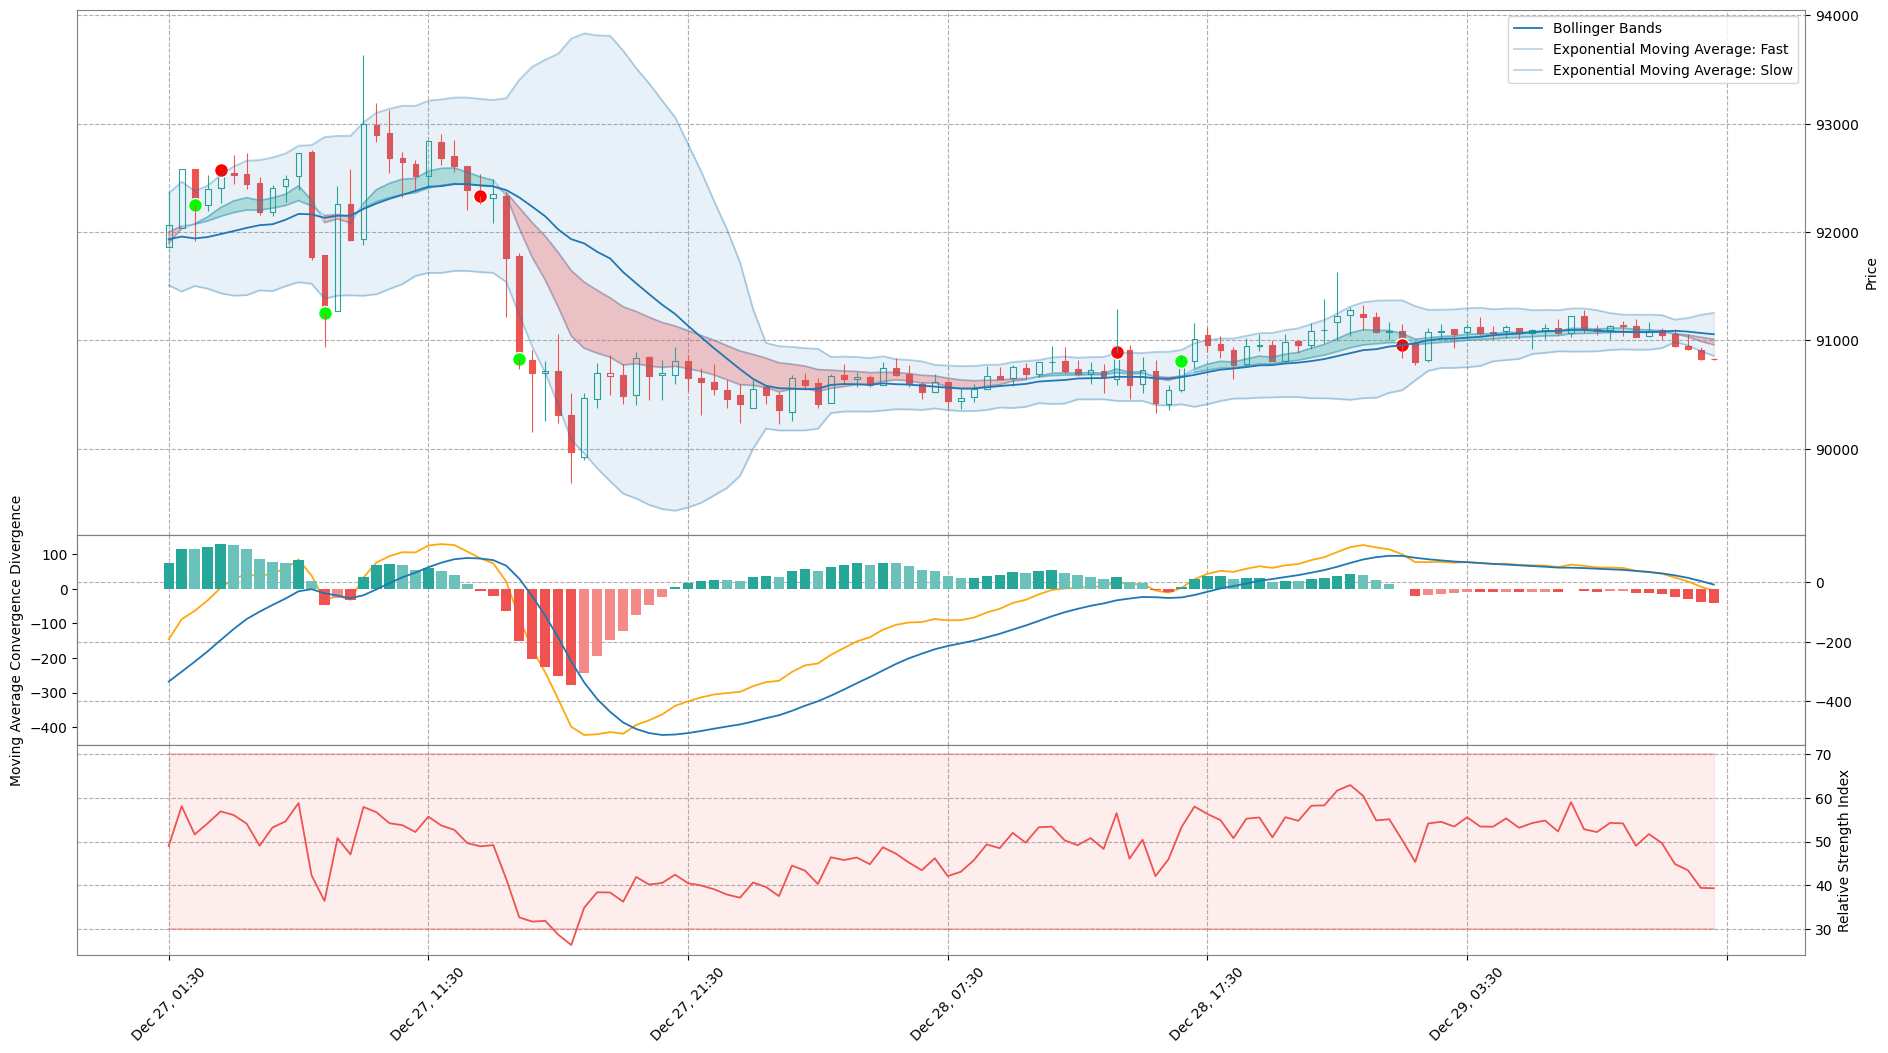

In [17]:
# Plot last 120 entries in candlestick chart
candlestick_chart = CandlestickChart(df.to_pandas().set_index(fn.DATETIME))
candlestick_chart.plot()

In [ ]:
# Backtest trade strategy
trade_strategy = TradeStrategy(df)
trade_strategy.backtest()

results = [
    ["Initial Capital (€)", trade_strategy.initial_capital],
    SEPARATING_LINE,
    ["No. Trades", len(trade_strategy.trades)],
    SEPARATING_LINE,
    [f"{fn.PROCEEDS} (€)", round(trade_strategy.proceeds, 2)],
    [f"{fn.TOTAL_RETURN} (%)", round(trade_strategy.total_return * 100, 2)],
]

print(tabulate(results))

In [8]:
# Create pandas DataFrame from trade strategy trades list
trades = pl.DataFrame(
    trade_strategy.trades,
    orient="row",
    schema=[
        (fn.TIMESTAMP, pl.Int64),
        (fn.ACTION, pl.Int32),
        (fn.TRADE_PRICE, pl.Float64),
        (fn.SHARES, pl.Float64),
        (fn.PROCEEDS, pl.Float64),
    ],
)

In [ ]:
# Visualize proceeds
proceeds = (
    trades.filter(pl.col(fn.ACTION) == cl.SELL)
    .select(fn.PROCEEDS)
    .head(280)
    .to_numpy()
    .cumsum()
)
index = np.arange(len(proceeds))

fig, ax = plt.subplots(figsize=(24, 13.5))

ax.plot(index, proceeds, color=co.PERSIAN_GREEN_MAIN, linewidth=2)
ax.fill_between(index, proceeds, alpha=0.2, color=co.PERSIAN_GREEN_MAIN)

ax.set_ylabel(f"{fn.PROCEEDS} (€)")
ax.set_xlabel("Trade")

plt.show()

In [ ]:
# Caclulate profit/loss for each trade
exits = trades.filter(pl.col(fn.ACTION) == cl.SELL)
exits = exits.drop(fn.ACTION)

# Define series with index number of each sell
index = pl.Series(fn.INDEX, list(range(0, len(exits))))

# Define series with calculated profit/loss for each trade
profit_loss = pl.Series(
    fn.PROFIT_LOSS,
    (exits[fn.PROCEEDS] - exits[fn.PROCEEDS].shift()) / exits[fn.PROCEEDS] * 100,
)

# Add both series to sells DataFrame
exits = exits.with_columns(
    profit_loss,
    index,
)

# Visualize profit/loss
columns = [
    fn.INDEX,
    fn.TIMESTAMP,
    fn.PROFIT_LOSS,
]

profit = exits.select(columns).filter(exits[fn.PROFIT_LOSS] >= 0)
loss = exits.select(columns).filter(exits[fn.PROFIT_LOSS] < 0)

fig, ax = plt.subplots(figsize=(24, 13.5))

ax.bar(
    profit[fn.INDEX].to_numpy(),
    profit[fn.PROFIT_LOSS].to_numpy(),
    color=co.PERSIAN_GREEN_MAIN,
)

ax.bar(
    loss[fn.INDEX].to_numpy(),
    loss[fn.PROFIT_LOSS].to_numpy(),
    color=co.IMPERIAL_RED_MAIN,
)

ax.set_xlabel(fn.INDEX)
ax.set_ylabel(f"{fn.PROFIT_LOSS} (%)")

plt.tight_layout()
plt.show()